# Introduction

We have two learning tasks that involve the same _kind_ of input data, but don't have exactly aligned samples. In each of the learning tasks we have different numbers of i.i.d. samples, but we don't have overlapping sets necessarily in terms of our input data. One other assumption we have baked into this model is that the weights, while given a set for each task, are shared from a parental prior, hence there is parameter sharing amongst the learning tasks, though not in our usual "classical" sense.

By appending zero-padding, we should be able to generalize this to multi-task neural network learning with non-overlapping samples. [Thomas Wiecki](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) has a great blog post on how to do it, though he didn't deal with the "number of samples" issue, which I tried to add here.

In [1]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

In [2]:
# We start with parental weights of length 4, one for each feature.
parental_weights = np.random.normal(loc=10, scale=3, size=(4,))
parental_weights

array([ 7.39746961, 10.86009347,  7.20584574, 11.46377445])

In [7]:
# We'll now generate new weights based on location=parental_weights,
# and scale=1, but one for each learning task (here there are 15 in total)
n_samps = 100
n_tasks = 50
n_weights = 4

child_weights = np.random.normal(loc=parental_weights, scale=3, size=(n_tasks, n_weights))
child_weights

array([[1.88588455e+00, 1.31813944e+01, 8.22651835e+00, 8.63721277e+00],
       [4.82056408e+00, 8.95939307e+00, 6.64797314e+00, 8.25365850e+00],
       [9.71400337e+00, 1.57251024e+01, 1.16970272e+01, 1.26767609e+01],
       [5.53953141e+00, 9.67520607e+00, 7.79219681e+00, 1.59331361e+01],
       [7.41050219e+00, 1.44266250e+01, 5.00608510e+00, 5.23606053e+00],
       [1.08427555e+01, 1.31051508e+01, 5.80377754e+00, 8.99606861e+00],
       [1.03677548e+01, 1.25972723e+01, 8.11698840e+00, 9.22544439e+00],
       [6.34980602e+00, 9.70595355e+00, 9.90397937e+00, 1.30553643e+01],
       [5.73078904e+00, 1.07944763e+01, 1.17318910e+01, 1.05008281e+01],
       [3.99429426e+00, 9.16010975e+00, 3.78072835e+00, 1.04218423e+01],
       [8.89269981e+00, 8.02467118e+00, 6.63258719e+00, 8.78733599e+00],
       [9.76217503e+00, 7.75257008e+00, 1.06908788e+01, 9.22313076e+00],
       [4.46906679e+00, 1.32300763e+01, 1.07207996e+01, 7.22506716e+00],
       [8.45989658e+00, 1.61194699e+01, 8.44508075e

These are the true weights of the system.

We are now going to attempt to learn them in a Bayesian fashion.

In [8]:
data = np.random.normal(loc=3, scale=4, size=(n_tasks, n_samps, n_weights))

# We are going to apply a mask that nulls out about 70% of the values in the data matrix,
# and replaces them with zeros.
null_mask = np.repeat(np.random.binomial(n=1, p=0.3, size=(n_samps, 1)), 4, axis=1)
data = data * null_mask

In [9]:
data.shape, child_weights.shape

((50, 100, 4), (50, 4))

Let's now generate the $y$s. As long as they are labelled as zero where the inputs are also labelled as zero, then we should be in an ok regime. 

By definition of the math at hand, they will be zero because we don't have any $X$ information to propagate forward (they are set to zero as inputs), so in this simulation setting, we are ok.

In [10]:
y = np.einsum("ijk, ik -> ij", data, child_weights)
y = y + np.random.normal(loc=0, scale=3, size=y.shape)

In [11]:
y.shape

(50, 100)

We are now going to write a hierarchical linear regression model that handles this particular case of imbalanced number of samples.

If we are able to recover back the original weights, then zero-padding could be a very powerful technique to deal with multiple learning tasks that also have non-equal numbers of samples that also have non-overlapping sample indices.

In [12]:
data.shape

(50, 100, 4)

In [13]:
child_weights.shape

(50, 4)

In [14]:
tt.batched_dot(data, child_weights)

BatchedDot.0

In [15]:
data.shape

(50, 100, 4)

In [16]:
y

array([[ 2.15677804e+00, -1.44648044e+00,  3.51543070e+00, ...,
         9.73690989e+01, -2.44901575e+00, -1.20493168e+00],
       [ 8.78838564e-02, -2.65644547e+00,  2.86785280e+00, ...,
         1.31203076e+02,  5.31745988e+00,  2.89468406e+00],
       [-3.47832598e+00, -4.87845749e-01,  3.70907724e+00, ...,
         1.45353111e+02,  6.83234225e-01, -1.75255584e+00],
       ...,
       [ 6.17317822e+00, -1.89882128e+00, -2.33811245e+00, ...,
         1.79808554e+02,  5.84767589e-02,  2.20340092e+00],
       [ 2.38162856e-01, -9.09623765e+00, -3.72147233e-02, ...,
         8.67388689e+01, -1.32916462e+00, -4.14104754e+00],
       [-2.25771748e+00, -1.18829771e+00, -1.30000751e+00, ...,
         2.01384277e+02, -4.44522251e+00, -5.29395634e+00]])

In [17]:
with pm.Model() as hierarchical_linear_model:
    w_parent = pm.Normal("w_parent", mu=0, sd=1, shape=(n_weights,))

    # Broadcasting will give us 4 child weights drawn from w_parent,
    # I think.
    w_child = pm.Normal("w_child", mu=w_parent, sd=1, shape=(n_tasks, n_weights))

    sd = pm.HalfCauchy("sd", beta=10)

    # mu = pm.Deterministic("mu", np.einsum('ijk, kj -> ij', data, w_child))
    mu = pm.Deterministic("mu", tt.batched_dot(data, w_child))
    like = pm.Normal("like", mu=mu, sd=sd, observed=y)

In [18]:
with hierarchical_linear_model:
    # trace = pm.sample(2000, cores=1)
    approx = pm.fit(100000)
    trace = approx.sample(2000)

Average Loss = 13,932: 100%|██████████| 100000/100000 [00:28<00:00, 3523.26it/s]  
Finished [100%]: Average Loss = 13,932


In [19]:
trace["w_child"]

array([[[ 1.967416 , 13.257001 ,  8.329166 ,  8.628999 ],
        [ 4.690891 ,  9.136066 ,  6.5901804,  8.541647 ],
        [ 9.432199 , 16.021608 , 11.593629 , 12.8588295],
        ...,
        [ 8.922573 , 17.37885  ,  6.6801944, 12.969812 ],
        [10.952263 ,  7.48547  ,  8.49139  , 17.341566 ],
        [ 5.3707466, 10.75534  , 13.190498 ,  7.2898607]],

       [[ 2.0008464, 12.867337 ,  8.127722 ,  8.192062 ],
        [ 4.8743544,  8.939325 ,  6.4923787,  8.380577 ],
        [ 9.42855  , 15.812643 , 11.29188  , 12.392779 ],
        ...,
        [ 9.024921 , 17.672672 ,  6.554825 , 12.875198 ],
        [10.662271 ,  7.403108 ,  8.358003 , 17.422035 ],
        [ 5.447894 , 10.844706 , 13.290672 ,  7.314574 ]],

       [[ 2.1692216, 12.891603 ,  8.235776 ,  8.337997 ],
        [ 4.762043 ,  9.181348 ,  6.5408077,  8.433302 ],
        [ 9.303247 , 15.811275 , 11.279292 , 12.812595 ],
        ...,
        [ 8.897922 , 17.53659  ,  6.720168 , 12.850064 ],
        [10.760367 ,  7.95322

In [20]:
trace["w_parent"].mean(axis=0)

array([ 7.3662996, 11.561948 ,  6.751883 , 11.460024 ], dtype=float32)

In [21]:
parental_weights

array([ 7.39746961, 10.86009347,  7.20584574, 11.46377445])

We're close!

In [22]:
trace["w_child"].mean(axis=0)

array([[ 2.0051434 , 12.944838  ,  8.2912655 ,  8.586497  ],
       [ 4.756403  ,  8.925725  ,  6.6113305 ,  8.460448  ],
       [ 9.413604  , 15.822277  , 11.482415  , 12.661848  ],
       [ 5.6023602 ,  9.456425  ,  7.9047804 , 15.638022  ],
       [ 7.528602  , 14.173123  ,  4.9499645 ,  5.686126  ],
       [10.823394  , 12.988305  ,  5.908422  ,  9.050325  ],
       [10.30909   , 12.452925  ,  8.014533  ,  9.386819  ],
       [ 6.428059  ,  9.491078  ,  9.88687   , 12.950765  ],
       [ 5.7104115 , 10.822237  , 11.75448   , 10.64193   ],
       [ 3.731501  ,  9.428005  ,  3.5264528 , 10.390358  ],
       [ 8.806088  ,  8.255748  ,  6.71134   ,  8.708556  ],
       [ 9.853503  ,  7.764982  , 10.56799   ,  9.401294  ],
       [ 4.5764036 , 13.0786295 , 10.492825  ,  7.3955035 ],
       [ 8.414475  , 15.807961  ,  8.392618  , 13.053631  ],
       [ 7.4781766 , 13.981478  ,  8.398752  , 13.604348  ],
       [ 9.324352  ,  9.2249975 ,  7.3410363 , 11.242141  ],
       [ 9.289938  , 15.

In [23]:
child_weights

array([[1.88588455e+00, 1.31813944e+01, 8.22651835e+00, 8.63721277e+00],
       [4.82056408e+00, 8.95939307e+00, 6.64797314e+00, 8.25365850e+00],
       [9.71400337e+00, 1.57251024e+01, 1.16970272e+01, 1.26767609e+01],
       [5.53953141e+00, 9.67520607e+00, 7.79219681e+00, 1.59331361e+01],
       [7.41050219e+00, 1.44266250e+01, 5.00608510e+00, 5.23606053e+00],
       [1.08427555e+01, 1.31051508e+01, 5.80377754e+00, 8.99606861e+00],
       [1.03677548e+01, 1.25972723e+01, 8.11698840e+00, 9.22544439e+00],
       [6.34980602e+00, 9.70595355e+00, 9.90397937e+00, 1.30553643e+01],
       [5.73078904e+00, 1.07944763e+01, 1.17318910e+01, 1.05008281e+01],
       [3.99429426e+00, 9.16010975e+00, 3.78072835e+00, 1.04218423e+01],
       [8.89269981e+00, 8.02467118e+00, 6.63258719e+00, 8.78733599e+00],
       [9.76217503e+00, 7.75257008e+00, 1.06908788e+01, 9.22313076e+00],
       [4.46906679e+00, 1.32300763e+01, 1.07207996e+01, 7.22506716e+00],
       [8.45989658e+00, 1.61194699e+01, 8.44508075e

Text(0, 0.5, 'fitted weight value')

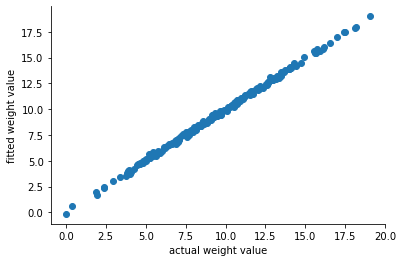

In [27]:
import matplotlib.pyplot as plt

plt.scatter(child_weights.ravel(), trace["w_child"].mean(axis=0).ravel())
plt.xlabel("actual weight value")
plt.ylabel("fitted weight value")

In [24]:
trace["w_child"].std(axis=0)

array([[0.14306226, 0.12947476, 0.11812667, 0.19399412],
       [0.09389646, 0.14685962, 0.13380034, 0.12360693],
       [0.13188644, 0.1345797 , 0.13485426, 0.11405891],
       [0.15594204, 0.13806307, 0.11253026, 0.11626544],
       [0.12601078, 0.13728812, 0.12075225, 0.1446327 ],
       [0.11005952, 0.12391454, 0.10360434, 0.12318951],
       [0.1497308 , 0.12567411, 0.11944677, 0.11589745],
       [0.130474  , 0.14298798, 0.11725897, 0.11386009],
       [0.13041745, 0.12613185, 0.12529357, 0.13069104],
       [0.13952228, 0.1319082 , 0.16522062, 0.13029064],
       [0.11604515, 0.13416022, 0.12118381, 0.13637666],
       [0.11043026, 0.11396095, 0.11776066, 0.15543215],
       [0.15274225, 0.16998142, 0.1718521 , 0.14279863],
       [0.14085582, 0.15778421, 0.15363741, 0.12155973],
       [0.16090673, 0.13934565, 0.13018191, 0.12999128],
       [0.15716586, 0.15683798, 0.15898661, 0.12149709],
       [0.1319872 , 0.15585274, 0.13117617, 0.12205315],
       [0.1252604 , 0.12869829,

OK! I think that this works, just that something is not right with NUTS because of gradient issues (we get zeros on diagonal of mass matrix). I'm going to show this experiment to the PyMC devs to see what I might be doing wrong.